Para entrar no modo apresentação, execute a seguinte célula e pressione `-`

In [2]:
%reload_ext slide

<IPython.core.display.Javascript object>

<span class="notebook-slide-start"/>

# Mineração de Repositórios (Parte 2)

Este notebook apresenta os seguintes tópicos:

- [API v4](#API-v4)
- [Git](#Git)
- [Exercício 9](#Exerc%C3%ADcio-9)
- [Pandas](#Pandas)
- [Exercício 10](#Exerc%C3%ADcio-10)
- [Pygit2](#Pygit2)
- [Exercício 11](#Exerc%C3%ADcio-10)

## API v4

Anteriormente, o minicurso abordou a API v3 do GitHub, que utiliza REST. Agora, o minicurso abordará a API v4, que usa GraphQL (https://developer.github.com/v4/).

Antes de qualquer coisa, vamos iniciar o servidor de proxy, caso ele esteja fechado:
```bash
python proxy.py https://api.github.com/
```

Além do servidor de proxy, precisamos carregar o token e preparar a função de autenticação.  <span class="notebook-slide-extra" data-count="2"/>

In [ ]:
from ipywidgets import FileUpload, interact
@interact(files=FileUpload())
def set_token(files={}):
    global token
    if files:
        for key, values in files.items():
            token = values['content'].decode("utf-8").strip()
            print("Token Loaded!")

In [1]:
import requests

def token_auth(request):
    request.headers["User-Agent"] = "Minicurso" # Necessário
    request.headers["Authorization"] = "token {}".format(token)
    return request

Agora podemos tentar conectar na API v4 e verificar se a autenticação funcionou. Note que usamos POST e URL original é https://api.github.com/graphql. <span class="notebook-slide-extra" data-count="2"/>

In [2]:
SITE = "http://localhost:5000/" # ou https://api.github.com

query = """
{
  rateLimit {
    limit
    cost
    remaining
    resetAt
  }
}
"""

response = requests.post(SITE + "graphql", json={'query': query}, auth=token_auth)
response.status_code

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /graphql (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6dea34b1d0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [3]:
response.json()

NameError: name 'response' is not defined

A consulta com a API v4 é um pouco mais verbosa, porém existe uma única URL de acesso e o resultado vem exatamente o que consultamos. <span class="notebook-slide-scroll" data-count="-1"/>

A seguir temos um exemplo de uma consulta quase completa em relação ao que fizemos na APIv3. <span class="notebook-slide-extra" data-count="1"/>

In [4]:
query = """
query {
  repository(owner:"gems-uff", name:"sapos") {
      stargazers {
          totalCount
      }
      forks {
          totalCount
      }
      watchers {
          totalCount
      }
      primaryLanguage {
          name
      }
      open_issues: issues(states:OPEN, first:100) {
          totalCount
          edges {
              node {
                  number
                  closedAt
                  createdAt
                  labels(first:100) {
                    edges { 
                      node {
                        name
                      }
                    }
                    pageInfo {
                      startCursor
                      hasNextPage
                      endCursor
                    }
                  }
              }
          }
          pageInfo {
            startCursor
            hasNextPage
            endCursor
          }
      }
      closed_issues: issues(states:CLOSED, first:100) {
          totalCount
          edges {
              node {
                  number
                  closedAt
                  createdAt
                  labels(first:100) {
                    edges { 
                      node {
                        name
                      }
                    }
                    pageInfo {
                      startCursor
                      hasNextPage
                      endCursor
                    }
                  }
              }
          }
          pageInfo {
            startCursor
            hasNextPage
            endCursor
          }
      }
      mentionableUsers(first:100) {
          edges {
              node {
                  login
              }
          }
          pageInfo {
            startCursor
            hasNextPage
            endCursor
          }
      }
  }
  
}
"""

response = requests.post(SITE + "graphql", json={'query': query}, auth=token_auth)
print(response.status_code)
data = response.json()
data

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /graphql (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6dea026c18>: Failed to establish a new connection: [Errno 111] Connection refused'))

Uma única consulta é capaz de retornar boa parte das informações que precisamos.

Mas ATENÇÃO! Paginação ainda é necessária e é feita com os argumentos `first:100` e `after:{endCursor}`. <span class="notebook-slide-extra" data-count="3"/>

In [5]:
data["data"]["repository"]["closed_issues"]["pageInfo"]

NameError: name 'data' is not defined

In [6]:
query_base = """
query {
  repository(owner:"gems-uff", name:"sapos") {
      closed_issues: issues(states:CLOSED, first:100, after:"%s") {
          totalCount
          edges {
              node {
                  number
                  closedAt
                  createdAt
                  labels(first:100) {
                    edges { 
                      node {
                        name
                      }
                    }
                    pageInfo {
                      startCursor
                      hasNextPage
                      endCursor
                    }
                  }
              }
          }
          pageInfo {
            startCursor
            hasNextPage
            endCursor
          }
      }
  }
}
"""
query = query_base % (data["data"]["repository"]["closed_issues"]["pageInfo"]['endCursor'], )

response = requests.post(SITE + "graphql", json={'query': query}, auth=token_auth)
print(response.status_code)
data2 = response.json()
data2

NameError: name 'data' is not defined

In [7]:
data2["data"]["repository"]["closed_issues"]["pageInfo"]

NameError: name 'data2' is not defined

Mais uma página. <span class="notebook-slide-extra" data-count="2"/>

In [8]:
query = query_base % (data2["data"]["repository"]["closed_issues"]["pageInfo"]['endCursor'], )

response = requests.post(SITE + "graphql", json={'query': query}, auth=token_auth)
print(response.status_code)
data3 = response.json()
data3

NameError: name 'data2' is not defined

In [9]:
data3["data"]["repository"]["closed_issues"]["pageInfo"]

NameError: name 'data3' is not defined

Foi a última. <span class="notebook-slide-scroll" data-position="-1"/>

### Schema

O schema da API v4 pode ser encontrado na documentação: https://developer.github.com/v4/object/repository/

Além disso, é possível fazer consultas para obter o schema. <span class="notebook-slide-extra" data-count="1"/>


In [10]:
SITE = "http://localhost:5000/" # ou https://api.github.com

query = """
query {
  __type(name: "Repository") {
    name
    kind
    description
    fields {
      name
      description
    }
  }
}
"""

response = requests.post(SITE + "graphql", json={'query': query}, auth=token_auth)
print(response.status_code)
response.json()

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /graphql (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6de9fc0208>: Failed to establish a new connection: [Errno 111] Connection refused'))

## Git

Outra fonte de informações de um repositório de software é o repositório do sistema de controle de versões.

Pelo controle de versões, conseguimos ter acesso a todos os arquivos de todas as versões, todas as mensagens de commit, branches, e colaboradores.

Nesta parte do minicurso, faremos a mineração dessas informações.

No caso do Git, ao clonar um repositório, ficamos com uma cópia local do que está lá. Portanto, começamos a mineração com um clone e não precisamos de nenhum proxy.  <span class="notebook-slide-extra" data-count="1"/>

In [11]:
!git clone https://github.com/gems-uff/sapos

fatal: destination path 'sapos' already exists and is not an empty directory.


Com o repositório clonado, podemos usar comandos do git para extrair informações.  <span class="notebook-slide-extra" data-count="2"/>

In [12]:
%cd sapos

/home/joao/projects/tutorial/sapos


In [47]:
!git branch -r

  origin/HEAD -> origin/master
  origin/bugfixes
  origin/hotfixes
  origin/master
  origin/reports


Essas informações também podem ser obtidas para tratarmos usando variáveis do Python.

A seguir tentamos descobrir qual é o commit de cada um desses branches. <span class="notebook-slide-extra" data-count="2"/>

In [51]:
git_branch_output = !git branch -r
branches = [
    branch.strip().split(' ')[0].split('/')[1]
    for branch in git_branch_output
]
branches

['HEAD', 'bugfixes', 'hotfixes', 'master', 'reports']

In [52]:
branch_commit = {}
for branch in branches:
    __ = !git checkout $branch
    commit = !git show --pretty=format:"%h" --no-patch
    branch_commit[branch] = commit
__ = !git checkout master
branch_commit

{'HEAD': ['d3e4307'],
 'bugfixes': ['d3e4307'],
 'hotfixes': ['d3e4307'],
 'master': ['d3e4307'],
 'reports': ['b294935']}

Usamos `__ = !...` para evitar a exibição do output do comando de sistema. O IPython imprime o output quando bang expressions são usadas isoladas e retorna o output quando elas são usadas em atribuições.

Note que apenas o branch `reports` está em um commit diferente.  <span class="notebook-slide-scroll" data-position="-1"/>

## Exercício 9

Faça a mesma operação para obter o código dos commits de tags e salve na variável `tag_commit`. <span class="notebook-slide-extra" data-count="1"/>

In [62]:
tags = !git tag
...

Agora vamos agrupar as tags por versões minor e ordenar as versões patch. <span class="notebook-slide-extra" data-count="1"/>

In [87]:
from itertools import groupby
groups = groupby(tags, lambda x: x.rsplit(".", 1)[0])
minor_tags = {}
for minor, elements in groups:
    minor_tags[minor] = sorted(
        elements,
        key=lambda x: int(x.split('-')[0].split('.')[-1])
    )
minor_tags['4.3']

['4.3.0',
 '4.3.1',
 '4.3.2',
 '4.3.3',
 '4.3.4',
 '4.3.5',
 '4.3.6',
 '4.3.7',
 '4.3.8',
 '4.3.9',
 '4.3.10',
 '4.3.11',
 '4.3.12',
 '4.3.13',
 '4.3.14']

Fazendo o mesmo para agrupar versões major. <span class="notebook-slide-extra" data-count="1"/>

In [92]:
groups = groupby(minor_tags, lambda x: x.rsplit(".", 1)[0])
major_tags = {}
for major, elements in groups:
    major_tags[major] = sorted(
        elements,
        key=lambda x: int(x.split('-')[0].split('.')[-1])
    )
major_tags['4']

['4.0', '4.1', '4.2', '4.3', '4.4']

Com isso, podemos escolher versões major (e.g., 3 e 4) e obter a última versão patch para cada minor delas. <span class="notebook-slide-extra" data-count="1"/>

In [137]:
last_patch_for_v3v4 = {
    minor: minor_tags[minor][-1]
    for minor in major_tags['3'] + major_tags['4']
}
last_patch_for_v3v4

{'3.0': '3.0.0',
 '3.1': '3.1.0',
 '3.2': '3.2.1',
 '3.3': '3.3.7',
 '4.0': '4.0.4',
 '4.1': '4.1.1',
 '4.2': '4.2.0',
 '4.3': '4.3.14',
 '4.4': '4.4.27'}

Agora queremos ver a evolução de linhas de código para as versões selecionadas. Para isso, vamos percorrer o dicionário fazendo checkout de cada versão, carregar o número de linhas usando `cloc` e parsear o resultado para extrair as colunas para construir linhas de uma tabela. <span class="notebook-slide-extra" data-count="1"/>

In [143]:
from collections import defaultdict
columns = {"id"}
rows = []

for minor, tag in last_patch_for_v3v4.items():
    __ = !git checkout $tag
    lines = !cloc .
    filtered_lines = lines[lines.index("-" * 79) + 3:]
    commit_result = defaultdict(int)
    commit_result["id"] = minor
    for line in filtered_lines:
        if not line.startswith("-"):
            split = line.split()
            language = split[0]
            commit_result[language + "_files"] = int(split[1])
            commit_result[language + "_blank"] = int(split[2])
            commit_result[language + "_comment"] = int(split[3])
            commit_result[language + "_code"] = int(split[4])
            columns |= {
                language + "_files", language + "_blank",
                language + "_comment", language + "_code"
            }
    rows.append(commit_result)

## Pandas
Podemos usar `pandas` para construir a tabela a partir da lista de dicionários.  <span class="notebook-slide-extra" data-count="1"/>

In [144]:
import pandas as pd
df = pd.DataFrame(rows)
df

,id,Ruby_files,Ruby_blank,Ruby_comment,Ruby_code,HTML_files,HTML_blank,HTML_comment,HTML_code,Sass_files,...,XML_comment,XML_code,SUM:_files,SUM:_blank,SUM:_comment,SUM:_code,CoffeeScript_files,CoffeeScript_blank,CoffeeScript_comment,CoffeeScript_code
0,3.0,336,1880,1362,19147,108,10891,22,15740,3,...,0.0,9.0,508,13520,1525,38849,NaN,NaN,NaN,NaN
1,3.1,336,1937,1363,19359,108,10891,22,15740,3,...,0.0,9.0,508,13582,1526,39079,NaN,NaN,NaN,NaN
2,3.2,364,2437,1385,21739,108,10891,22,15740,8,...,0.0,9.0,546,14249,1643,42458,NaN,NaN,NaN,NaN
3,3.3,396,2749,1527,23319,109,10901,22,15887,8,...,0.0,9.0,583,14604,1790,44486,NaN,NaN,NaN,NaN
4,4.0,447,2965,1653,24719,109,10903,22,15799,8,...,0.0,9.0,645,14903,1966,46478,NaN,NaN,NaN,NaN
5,4.1,449,2977,1667,24759,109,10903,22,15799,8,...,0.0,9.0,647,14917,1980,46532,NaN,NaN,NaN,NaN
6,4.2,449,2978,1667,24767,109,10903,22,15799,8,...,0.0,9.0,647,14918,1980,46540,NaN,NaN,NaN,NaN
7,4.3,505,3221,2100,25564,5,28,22,227,9,...,NaN,NaN,594,4237,2418,31506,1.0,0.0,3.0,0.0
8,4.4,508,3186,2042,25765,4,16,22,168,9,...,NaN,NaN,600,4192,2321,31740,1.0,0.0,3.0,0.0


O `pandas` permite descrever a tabela com o método `.describe()`.  <span class="notebook-slide-extra" data-count="1"/>

In [149]:
df.describe()

,Ruby_files,Ruby_blank,Ruby_comment,Ruby_code,HTML_files,HTML_blank,HTML_comment,HTML_code,Sass_files,Sass_blank,...,XML_comment,XML_code,SUM:_files,SUM:_blank,SUM:_comment,SUM:_code,CoffeeScript_files,CoffeeScript_blank,CoffeeScript_comment,CoffeeScript_code
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,...,7.0,7.0,9.000000,9.000000,9.000000,9.000000,2.0,2.0,2.0,2.0
mean,421.111111,2703.333333,1640.666667,23237.555556,85.444444,8480.777778,22.0,12322.111111,7.111111,319.666667,...,0.0,9.0,586.444444,12124.666667,1905.444444,40852.000000,1.0,0.0,3.0,0.0
std,66.325795,507.187589,275.371113,2566.055587,45.894202,4795.680160,0.0,6874.179268,2.368778,23.690715,...,0.0,0.0,55.854971,4516.526874,320.371703,6016.483711,0.0,0.0,0.0,0.0
min,336.000000,1880.000000,1362.000000,19147.000000,4.000000,16.000000,22.0,168.000000,3.000000,277.000000,...,0.0,9.0,508.000000,4192.000000,1525.000000,31506.000000,1.0,0.0,3.0,0.0
25%,364.000000,2437.000000,1385.000000,21739.000000,108.000000,10891.000000,22.0,15740.000000,8.000000,315.000000,...,0.0,9.0,546.000000,13520.000000,1643.000000,38849.000000,1.0,0.0,3.0,0.0
50%,447.000000,2965.000000,1653.000000,24719.000000,108.000000,10891.000000,22.0,15740.000000,8.000000,333.000000,...,0.0,9.0,594.000000,14249.000000,1966.000000,42458.000000,1.0,0.0,3.0,0.0
75%,449.000000,2978.000000,1667.000000,24767.000000,109.000000,10903.000000,22.0,15799.000000,8.000000,334.000000,...,0.0,9.0,645.000000,14903.000000,1980.000000,46478.000000,1.0,0.0,3.0,0.0
max,508.000000,3221.000000,2100.000000,25765.000000,109.000000,10903.000000,22.0,15887.000000,9.000000,336.000000,...,0.0,9.0,647.000000,14918.000000,2418.000000,46540.000000,1.0,0.0,3.0,0.0


Além disso, é possível fazer seleções nos dados. <span class="notebook-slide-extra" data-count="1"/>

In [162]:
df[df["Ruby_code"] > 25000]

,id,Ruby_files,Ruby_blank,Ruby_comment,Ruby_code,HTML_files,HTML_blank,HTML_comment,HTML_code,Sass_files,...,XML_comment,XML_code,SUM:_files,SUM:_blank,SUM:_comment,SUM:_code,CoffeeScript_files,CoffeeScript_blank,CoffeeScript_comment,CoffeeScript_code
7,4.3,505,3221,2100,25564,5,28,22,227,9,...,NaN,NaN,594,4237,2418,31506,1.0,0.0,3.0,0.0
8,4.4,508,3186,2042,25765,4,16,22,168,9,...,NaN,NaN,600,4192,2321,31740,1.0,0.0,3.0,0.0


## Exercício 10

Selecione as versões que usam CoffeeScript e as versões que não usam XML.


Além de selecionar linhas, podemos selecionar colunas. <span class="notebook-slide-extra" data-count="1"/>

In [172]:
columns = ['SUM:_files', 'SUM:_blank', 'SUM:_comment', 'SUM:_code']
ndf = df[columns]
ndf

,SUM:_files,SUM:_blank,SUM:_comment,SUM:_code
0,508,13520,1525,38849
1,508,13582,1526,39079
2,546,14249,1643,42458
3,583,14604,1790,44486
4,645,14903,1966,46478
5,647,14917,1980,46532
6,647,14918,1980,46540
7,594,4237,2418,31506
8,600,4192,2321,31740


O `pandas` também oferece algumas funções que facilitam a geração de gráficos. <span class="notebook-slide-extra" data-count="2"/>

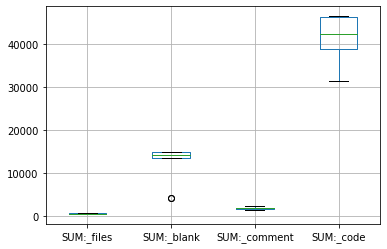

In [174]:
%matplotlib inline
ndf.boxplot()

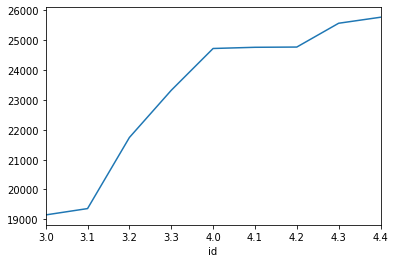

In [177]:
df.set_index("id")["Ruby_code"].plot()

É possível aplicar operações em colunas e criar novas colunas. <span class="notebook-slide-extra" data-count="1"/>

In [181]:
df.loc[:, "tag"] = df["id"].apply(lambda minor: last_patch_for_v3v4[minor])

In [182]:
df

,id,Ruby_files,Ruby_blank,Ruby_comment,Ruby_code,HTML_files,HTML_blank,HTML_comment,HTML_code,Sass_files,...,XML_code,SUM:_files,SUM:_blank,SUM:_comment,SUM:_code,CoffeeScript_files,CoffeeScript_blank,CoffeeScript_comment,CoffeeScript_code,tag
0,3.0,336,1880,1362,19147,108,10891,22,15740,3,...,9.0,508,13520,1525,38849,NaN,NaN,NaN,NaN,3.0.0
1,3.1,336,1937,1363,19359,108,10891,22,15740,3,...,9.0,508,13582,1526,39079,NaN,NaN,NaN,NaN,3.1.0
2,3.2,364,2437,1385,21739,108,10891,22,15740,8,...,9.0,546,14249,1643,42458,NaN,NaN,NaN,NaN,3.2.1
3,3.3,396,2749,1527,23319,109,10901,22,15887,8,...,9.0,583,14604,1790,44486,NaN,NaN,NaN,NaN,3.3.7
4,4.0,447,2965,1653,24719,109,10903,22,15799,8,...,9.0,645,14903,1966,46478,NaN,NaN,NaN,NaN,4.0.4
5,4.1,449,2977,1667,24759,109,10903,22,15799,8,...,9.0,647,14917,1980,46532,NaN,NaN,NaN,NaN,4.1.1
6,4.2,449,2978,1667,24767,109,10903,22,15799,8,...,9.0,647,14918,1980,46540,NaN,NaN,NaN,NaN,4.2.0
7,4.3,505,3221,2100,25564,5,28,22,227,9,...,NaN,594,4237,2418,31506,1.0,0.0,3.0,0.0,4.3.14
8,4.4,508,3186,2042,25765,4,16,22,168,9,...,NaN,600,4192,2321,31740,1.0,0.0,3.0,0.0,4.4.27


Existem muitas outras operações que podem ser vistas na documentação: https://pandas.pydata.org/pandas-docs/stable/. <span class="notebook-slide-scroll" data-position="-1"/>

## Pygit2

Conseguimos extrair informações do git usando comandos de sistema e parseando os resultados como fizemos anteriormente.

Porém, comandos de sistema nem sempre são a alternativa mais rápida e existe um esforço em parsear as informações.

Nesta parte do minicurso, falarei da biblioteca `pygit2`, que permite acessar e extrair informações diretamente do repositório.

Inicialmente, vamos carregar o repositório. <span class="notebook-slide-extra" data-count="3"/>

In [185]:
import pygit2

In [188]:
repo_path = pygit2.discover_repository(".")
repo_path

'/home/joao/projects/tutorial/sapos/.git/'

In [189]:
repo = pygit2.Repository(repo_path)

A partir do objeto do repositório, podemos ver em que commit ou tag estamos. <span class="notebook-slide-extra" data-count="1"/>

In [192]:
repo.describe()

'4.4.27'

Note que o resultado foi a última tag que fizemos checkout, que também é o branch `master`. <span class="notebook-slide-scroll" data-position="-1"/>

Podemos fazer checkout de commits usando a `pygit2`. <span class="notebook-slide-extra" data-count="2"/>

In [260]:
commit = repo.revparse_single("e82315c3ef")
repo.checkout_tree(
    commit,
)
repo.set_head(commit.oid)

In [261]:
repo.describe()

'4.0.0'

O checkout de branches é mais simples. <span class="notebook-slide-extra" data-count="2"/>

In [262]:
master = repo.lookup_branch("master")
repo.checkout(master)

In [263]:
repo.describe()

'4.4.27'

Com um objeto de commit, podemos extrair informações dele. <span class="notebook-slide-extra" data-count="5"/>

In [257]:
commit.oid

e82315c3efeb7b29dd43792fd77d840c229d7dcb

In [242]:
commit.author.name, commit.author.email

('Joao Felipe', 'joaofelipenp@gmail.com')

In [246]:
commit.commit_time

1409504044

In [252]:
commit.message

"Merge tag '4.0.0-migration'\n"

In [255]:
commit.parent_ids

[b3d4c3780c06255346ce42d1df7aacb22827c90a,
 3b8122326f5e8ffddd7888d2e601ff17e412e871]

Note que por ser um merge, o commit possui dois pais. <span class="notebook-slide-scroll" data-count="-1"/>

A `pygit2` também possui funções para caminhar pelos commits do repositório. <span class="notebook-slide-extra" data-count="1"/>

In [267]:
last_commit = repo[repo.head.target]
i = 0
for commit in repo.walk(last_commit.id, pygit2.GIT_SORT_TIME):
    print(str(commit.id)[:8], commit.message)
    i += 1
    if i >= 3:
        break

d3e43077 #300 updating devise gem from 4.6.2 to 4.7.1 due security vulnerability

0f5588e3 #299 updating nokogiri gem from 1.10.1 to 1.10.4 due security vulnerability

ae8746e8 Merge branch 'bugfixes'



A forma de caminhar pode variar de acordo com o segundo argumento:
    
- `GIT_SORT_NONE`: Sem ordem determinada
- `GIT_SORT_TOPOLOGICAL`: Ordem topológica - pais antes de filhos
- `GIT_SORT_TIME`: Momento do commit
- `GIT_SORT_REVERSE`: Ordem inversa

Esses argumentos podem ser combinados. Se eu quiser caminhar no inverso da ordem dos commits, posso fazer:
```python
    GIT_SORT_TIME | GIT_SORT_REVERSE
```

A seguir, usamos essa forma combinada para pegar o primeiro commit do projeto. <span class="notebook-slide-extra" data-count="1"/>

In [282]:
order = pygit2.GIT_SORT_TIME | pygit2.GIT_SORT_REVERSE
it = iter(repo.walk(last_commit.id, order))
first_commit = next(it)
first_commit.id, first_commit.message

(cf1efe3addbd8bc8208ca687c14f3181588e9ff0, 'Files generated by rails new.')

Podemos usar essa navegação para contar a quantidade de commits no histórico. <span class="notebook-slide-extra" data-count="1"/>

In [284]:
len(list(repo.walk(last_commit.id)))

1391

Mas note que esse não é o número total de commits do projeto! Ele apenas representa o número de commits no histórico do último commit.

Outros commits podem estar em branches ou até mesmo pendurados. <span class="notebook-slide-scroll" data-position="-1"/>

Para pegar todos os commits, precisamos iterar nos objetos do git e selecionar objetos que são commits. <span class="notebook-slide-extra" data-count="2"/>

In [279]:
commits = []
for oid in repo:
    obj = repo.get(oid)
    if isinstance(obj, pygit2.Commit):
        commits.append(obj)

In [280]:
len(commits)

1412

Agora temos todos os commits. <span class="notebook-slide-scroll" data-position="-1"/>

Em seguida, tentamos descobrir quais são os commits que não estão no histórico do `master`. <span class="notebook-slide-extra" data-count="1"/>

In [290]:
diff = set(commits) - set(repo.walk(last_commit.id))
for commit, _ in zip(diff, range(5)):
    print(str(commit.id)[:8], commit.message)


3224c137 Mais arquivos do cucumber

bea93f01 Criacao de alguns testes para alunos

4d221761 #296 implementing query_param_spec and fixing query_param bugs

60bec845 Controllers e rotas de report e report params

b294935c Remoçao dos arquivos do neatbeans



Quanto listamos os branches no início deste notebook, apenas o `reports` não estava no mesmo commit que o `master`. Desta forma, podemos ver se os commits que não estão no `master` são commits do `reports`ou se estão pendurados.

A seguir verificamos se algum daqueles commits está pendurado. <span class="notebook-slide-extra" data-count="1"/>

In [293]:
new_diff = diff - set(repo.walk(repo.revparse_single("reports").id))
for commit in new_diff:
    print(str(commit.id)[:8], commit.message)

69b272da #254 adding a variable to enable or disable if professors can post grades

70cccb2d #298 adding create header labels to pages that did not have them

50f1f600 #297 adding rspec presence tests to model Query and fixing them

4d221761 #296 implementing query_param_spec and fixing query_param bugs



Esses quatro commits estão pendurados. <span class="notebook-slide-scroll" data-position="-1"/>

Outra coisa que podemos fazer com a navegação nos commits é construir uma linha do tempo mostrando quais foram os momentos em que ocorreram mais commits.

Começamos calculando quantos dias se passaram desde o primeiro commit até hoje, preparando um array de dias, e inicializando um array de zeros. <span class="notebook-slide-extra" data-count="2"/>

In [296]:
from datetime import datetime
first_date = datetime.fromtimestamp(first_commit.commit_time)
first_date

datetime.datetime(2011, 7, 18, 10, 2, 10)

In [299]:
import numpy as np
today = datetime.today()
delta = today - first_date
days = delta.days
indexes = np.arange(days)
values = np.zeros(days)
days

3020

Navegamos nos commits atualizando values para considerar a contribuição de cada commit novo. <span class="notebook-slide-extra" data-count="1"/>

In [300]:
for commit in commits:
    date = datetime.fromtimestamp(commit.commit_time)
    delta = date - first_date
    delta_index = delta.days
    values[delta_index:] += 1

Plotamos o gráfico. <span class="notebook-slide-extra" data-count="1"/>

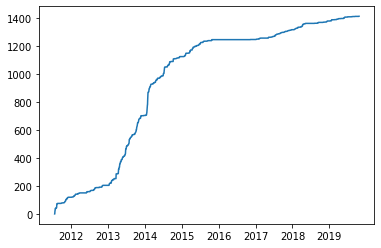

In [301]:
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

labels = [datetime(2011 + i, 1, 1) for i in range(ceil(delta.days / 365))]
label_indexes = [(label - first_date).days for label in labels]
label_years = [label.year for label in labels]
plt.xticks(label_indexes, label_years)
plt.plot(indexes, values)
plt.show()

## Exercício 11

Faça um gráfico mostrando o histórico de contribuições de cada usuário.